# Effective Mass Calculations

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [2]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [3]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

TODO: make plot for the symmetric case that compares with the perturbation theory - now fixed the coupling points for which we want to compare! Cluster calculations for this are running, don't forget to collect them!! Also, a side benefit is that they provide nice convergence with system size calculations now!!

## Ferro-Order Effective Masses
Read in the vGH calculations from the wavefunctions.

In [27]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo = np.array([2,4,20,40,60,80,100])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_B_2_q0 = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_B_2_qx = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [28]:
def var_eff_mass(E_q, E_0, t, M):
    m_0_finite_diff = (t*M**2*(1-np.cos(2*np.pi/M))/np.pi**2)**(-1)
    return ((2*(E_q-E_0)/(2*np.pi/M)**2)**(-1))/m_0_finite_diff

In [29]:
import scipy 

def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo = var_eff_mass(E_vGH_fo_B_2_qx, E_vGH_fo_B_2_q0, tx, Mx)
print('mx =', mx_fo)


popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo, mx_fo.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit = np.linspace(V_0_range_fo[0], V_0_range_fo[-1], 100)
y_fit = func(x_fit, *popt)

print('\nFit params =', popt)

mx = [1.00026131-9.01009509e-15j 1.00110194+9.02382594e-15j
 1.02948376+3.09628763e-14j 1.12157874+5.74958358e-15j
 1.28616856-2.62099845e-16j 1.54617687-1.14196437e-14j
 1.94922781-9.26774791e-14j]

Fit params = [1.00000000e+00 2.00000000e+00 9.08090548e-05]


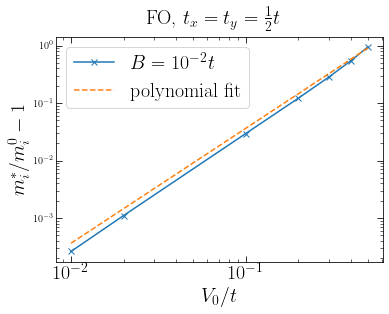

In [30]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')
axs.plot(x_fit/t, y_fit.real-1, color='tab:orange', linestyle='dashed', label=r'polynomial fit')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

In [11]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx_fdv = 80
My_fdv = 80

V_0_range_fdv = np.array([100,120,140])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_0'
folder = 'results/eff_mass/fdv/'
E_vGH_fdv_B_2_q0 = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_1'
E_vGH_fdv_B_2_qy = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)

In [12]:
my_fdv = var_eff_mass(E_vGH_fdv_B_2_qy, E_vGH_fdv_B_2_q0, ty, My_fdv)
print('my =', my_fdv)

my = [163.44371796-2.20852260e-10j 182.85940113+3.22530626e-10j
 204.02158292-2.22291776e-09j]


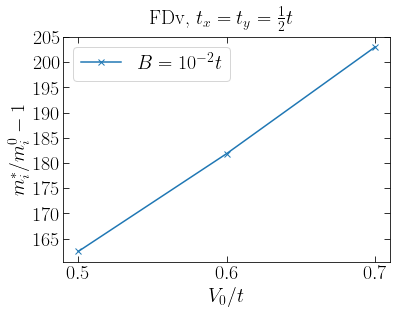

In [13]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FDv, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_fdv/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
#axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

In [14]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx_sp = 32
My_sp = 32

V_0_range_sp = np.array([150,170,190,210,250,300,350,500,1000,1500])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_0'
folder = 'results/eff_mass/sp/'
E_vGH_sp_B_2_q0 = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_1'
E_vGH_sp_B_2_qy = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_1_qy_0'
E_vGH_sp_B_2_qx = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

In [15]:
mx_sp = var_eff_mass(E_vGH_sp_B_2_qx, E_vGH_sp_B_2_q0, ty, Mx_sp)
my_sp = var_eff_mass(E_vGH_sp_B_2_qy, E_vGH_sp_B_2_q0, ty, My_sp)

print('mx =', mx_sp)
print('my =', my_sp)

mx = [2.66043406e+04+1.18450569e-08j 4.66356776e+04-1.16657864e-07j
 7.84379751e+04+7.20475446e-08j 1.27685843e+05-1.08039650e-07j
 3.13612097e+05+1.88008936e-05j 8.65483655e+05+2.00730373e-04j
 2.18302154e+06-3.12997133e-04j 2.42281640e+07-1.23238137e-02j
 9.66901951e+09+2.30141492e+04j 8.45072282e+11-1.38527603e+08j]
my = [2.66043323e+04-5.13769130e-08j 4.66356773e+04-3.57928708e-08j
 7.84380310e+04-4.18060477e-07j 1.27685714e+05-5.40129665e-07j
 3.13612178e+05+1.18421418e-05j 8.65485871e+05-1.85735372e-06j
 2.18282841e+06-1.47520424e-04j 2.42279904e+07+2.92117311e-02j
 9.69119616e+09+9.29557342e+03j 1.40845368e+12-4.74020249e+08j]


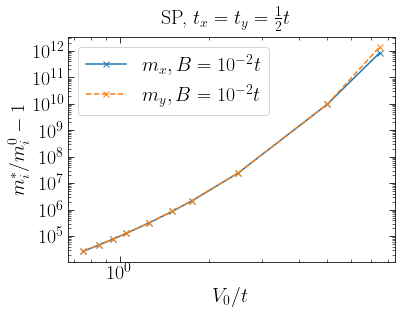

In [16]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'SP, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_sp/t, mx_sp.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs.plot(V_0_range_sp/t, my_sp.real-1, color='tab:orange', marker='x', linestyle='dashed', label=r'$m_y, B = 10^{-2} t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_sp/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

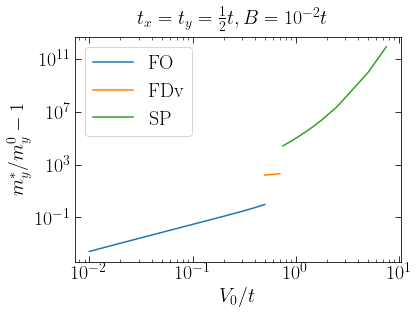

In [17]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'$t_x=t_y=\frac{1}{2}t, B = 10^{-2} t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', linestyle='solid', label=r'FO')
axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:orange', linestyle='solid', label=r'FDv')
axs.plot(V_0_range_sp/t, mx_sp.real-1, color='tab:green', linestyle='solid', label=r'SP')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_y^*/m_y^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/eff_mass/eff_mass_sym_case_B_2.0.pdf', bbox_inches='tight', dpi=50)

## Ferro-Order Effective Masses in asymmetric regime

Note: this calculation is finished tomorrow after Salsa!

In [46]:
tx = 150
ty = 50
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo_as = np.array([2,4,20,50])

check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_as_B_2_q0 = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_as_B_2_qx = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_1'
E_vGH_fo_as_B_2_qy = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

In [56]:
import scipy 

def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qx, E_vGH_fo_as_B_2_q0, tx, Mx)
print('mx =', mx_fo_as)

my_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qy, E_vGH_fo_as_B_2_q0, ty, My)
print('my =', my_fo_as)

popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo_as, mx_fo_as.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit_as = np.linspace(V_0_range_fo_as[0], V_0_range_fo_as[-1], 100)
y_fit_as = func(x_fit_as, *popt)

print('\nFit params =', popt)

mx = [1.00031841-4.50693934e-15j 1.00133164-1.58002282e-14j
 1.03523986+2.65205328e-14j 1.23412407+6.58597677e-15j]
my = [1.00044992-3.60436422e-14j 1.001883  +1.35557019e-14j
 1.05014679-3.95597231e-14j 1.35614178+7.08469151e-14j]

Fit params = [1.00000000e+00 2.00000000e+00 9.35106494e-05]


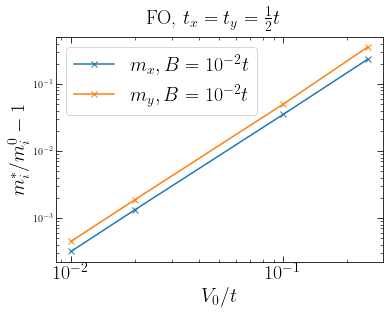

In [57]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs.plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y, B = 10^{-2} t$')
#axs.plot(x_fit_as/t, y_fit_as.real-1, color='tab:blue', linestyle='dashed', label=r'polynomial fit')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)